In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import

In [ ]:
# !pip install deeplake
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=3365edec7f1a9690a142e60e300ac35ee6a148ec2c721867698baad2a6cf7a53
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=9d5b6de246de6f7e53ba46a523d3a1318c3d4c087b3e5e54ccf9c8671eb040fb
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
import logging
import torch, torchvision
import pickle
import time
import os
import random
import warnings
# import deeplake
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from fvcore.nn import FlopCountAnalysis
from torchvision.transforms import v2
import time
from IPython.display import clear_output
from drive.MyDrive.GreenEdge.Pretrained.utils import EarlyExitCustomNet64, CreateDataset, EarlyExitCustomNet128

#Hide warnings
logging.basicConfig(filename='app.log',
    level=logging.CRITICAL,
    force=True,
)

In [ ]:
path = "/content/drive/MyDrive/GreenEdge/Pretrained"
data_path = "/content/drive/MyDrive/GreenEdge/"

batches_size = 256

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)

Device: cuda


## Dataset definition

In [ ]:
# Create dataset and dataloader

# validation_dataset_64 = CreateDataset(augmentation = True, train = False, data_path = data_path)
validation_dataset_128 = CreateDataset(augmentation = True, train = True, data_path = data_path, resize = 128)

# val_dataloader_64 = DataLoader(validation_dataset_64, batch_size=batches_size,
#                         shuffle=False, num_workers=0)
val_dataloader_128 = DataLoader(validation_dataset_128, batch_size=batches_size,
                        shuffle=False, num_workers=0)

## Model Test

In [ ]:
model_50 = path + "/models/resnet50earlycutmix_model.torch"
model_50X = path + "/models/resnext50earlycutmix_64_model.torch"
model_50_128 = path + "/Resize/ResNet50_128_parameters.torch"
model_50X_128 = path + "/Resize/ResNeXt50_128_parameters.torch"

In [ ]:
Threshold = np.linspace(0,7, 11)

In [ ]:
# Loading the models with different entropy threshold
models = []
weights = []
for T in Threshold:
  # models.append(EarlyExitCustomNet64(device,resnext = False,T=T))
  # weights.append(torch.load(model_50))
  models.append(EarlyExitCustomNet128(device,T=T))
  weights.append(torch.load(model_50X_128 ))
  # models.append(EarlyExitCustomNet64(device,T=T))
  # weights.append(torch.load(model_50X))
  models.append(EarlyExitCustomNet128( device, resnext = False, T=T))
  weights.append(torch.load(model_50_128 ))

<ipython-input-15-ac29aee41c3c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights.append(torch.load(model_50X_128 ))
<ipython-input-15-ac29aee41c3c>:12: FutureWarning

In [ ]:
acc = []
flop = []
for j, (model, weight) in enumerate(zip(models, weights)):
        print( f"################# {j} ###############")
        model.load_state_dict(weight)
        model.to(device)
        model.eval()

        start = time.time()
        total =  0
        total_flops = 0
        correct = 0

        y_true=[]
        y_pred=[]

        # hist=[]

        val_dataloader = val_dataloader_128 #if j % 2 == 0 else val_dataloader_128
        with torch.no_grad():
            for i, data in enumerate(val_dataloader):

                # print(f"BATCH {i}")

                inputs = data['images']
                inputs = inputs.to(device)


                labels = torch.squeeze(data['labels'])
        #         labels = torch.LongTensor([labels_map[label.item()] for label in labels])
                labels = labels.to(device)


                outputs = model(inputs.float())
                outputs.to(device)

                predicted = model(inputs.float())

                # _, predicted = torch.max(outputs.data, 1)

                y_pred.append(predicted)
                y_true.append(labels)

                # Compute FLOPs
                flops = FlopCountAnalysis(model, inputs).tracer_warnings(mode='none')
                total_flops += flops.total()/10**9 # in Giga Flops

                print(f"FLOPS {flops.total()}")

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if i == 200:
                  break

                #loss = loss_fn(outputs, labels)
                #loss = loss_fn(predicted, labels)
                #loss_batch = loss.detach().cpu().numpy()


            energy = total_flops / total
            test_acc = 100 * correct / total

            acc.append(test_acc)
            flop.append(energy)

        end = time.time()
        print(f"################### Time: {end-start} ######################")


################# 0 ###############
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 650280697856
FLOPS 65028069

In [ ]:
print("acc = ", acc)
print("flop = ",flop)

acc =  [93.84717039800995, 89.0663868159204, 93.67615049751244, 88.95172574626865, 92.81716417910448, 87.67490671641791, 89.97784514925372, 84.90749378109453, 84.08737562189054, 78.15415111940298, 72.73009950248756, 66.04283271144278, 57.53264925373134, 50.792910447761194, 54.24440298507463, 46.64373445273632, 54.03257151741293, 46.40663868159204, 53.98592972636816, 46.44939365671642, 54.269667288557216, 46.593205845771145]
flop =  [2.54015897599999, 2.4918753279999946, 2.3817657816517417, 2.350401258348258, 2.1994661877810944, 2.2047534589452744, 2.003635187900498, 2.0333276185472644, 1.7627888525373148, 1.8025373395422877, 1.45591740720398, 1.4881745932736328, 1.0992369999601994, 1.1298596846169162, 1.0185605119999956, 1.0287841280000039, 1.0185605119999956, 1.0287841280000039, 1.0185605119999956, 1.0287841280000039, 1.0185605119999956, 1.0287841280000039]


In [4]:
import matplotlib.pyplot as plt

In [5]:
flop = [0.6232760319999998, 2.5401589760000003, 0.6353469439999995, 2.491875328000002, 0.5795743211520001, 2.4431966814208, 0.6015775629311999, 2.3948810321920004, 0.5353370767359998, 2.3172579475456, 0.5642347585536002, 2.2866118901759998, 0.48407488716800007, 2.1454147485696002, 0.5175347339264, 2.1338980351999988, 0.41783760895999983, 1.9010422865919998, 0.45417077473280015, 1.9071922339839995, 0.330092969984, 1.5398051954688001, 0.35772901621760006, 1.5627843665920003, 0.2631927255040001, 1.1088128688127998, 0.266657255424, 1.151292964864, 0.2571960320000001, 1.0185605120000003, 0.2546401280000001, 1.0287841280000003, 0.2571960320000001, 1.0185605120000003, 0.2546401280000001, 1.0287841280000003, 0.2571960320000001, 1.0185605120000003, 0.2546401280000001, 1.0287841280000003, 0.2571960320000001, 1.0185605120000003, 0.2546401280000001]
acc = [71.59, 82.02, 72.0, 79.92, 71.49, 81.86, 71.87, 79.86, 70.29, 80.67, 70.96, 78.86, 67.0, 77.2, 68.45, 75.77, 61.08, 69.8, 63.48, 68.13, 51.83, 56.1, 54.18, 54.33, 43.89, 38.77, 43.57, 38.14, 43.26, 35.44, 42.33, 33.49, 43.26, 35.44, 42.33, 33.49, 43.26, 35.44, 42.33, 33.49, 43.26, 35.44, 42.33]
print(acc)
print(flop)

[71.59, 82.02, 72.0, 79.92, 71.49, 81.86, 71.87, 79.86, 70.29, 80.67, 70.96, 78.86, 67.0, 77.2, 68.45, 75.77, 61.08, 69.8, 63.48, 68.13, 51.83, 56.1, 54.18, 54.33, 43.89, 38.77, 43.57, 38.14, 43.26, 35.44, 42.33, 33.49, 43.26, 35.44, 42.33, 33.49, 43.26, 35.44, 42.33, 33.49, 43.26, 35.44, 42.33]
[0.6232760319999998, 2.5401589760000003, 0.6353469439999995, 2.491875328000002, 0.5795743211520001, 2.4431966814208, 0.6015775629311999, 2.3948810321920004, 0.5353370767359998, 2.3172579475456, 0.5642347585536002, 2.2866118901759998, 0.48407488716800007, 2.1454147485696002, 0.5175347339264, 2.1338980351999988, 0.41783760895999983, 1.9010422865919998, 0.45417077473280015, 1.9071922339839995, 0.330092969984, 1.5398051954688001, 0.35772901621760006, 1.5627843665920003, 0.2631927255040001, 1.1088128688127998, 0.266657255424, 1.151292964864, 0.2571960320000001, 1.0185605120000003, 0.2546401280000001, 1.0287841280000003, 0.2571960320000001, 1.0185605120000003, 0.2546401280000001, 1.0287841280000003, 

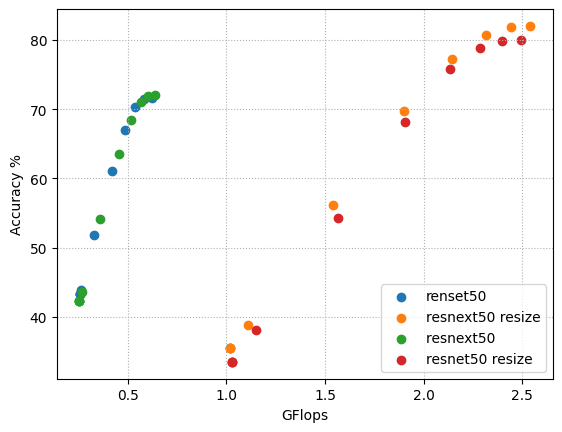

In [6]:
plt.scatter(flop[0::4],acc[0::4], label = "renset50")
plt.scatter(flop[1::4],acc[1::4],label = "resnext50 resize")
plt.scatter(flop[2::4],acc[2::4],label = "resnext50 ")
plt.scatter(flop[3::4],acc[3::4], label = "resnet50 resize")
plt.legend()
plt.xlabel("GFlops")
plt.ylabel("Accuracy %")
plt.grid(linestyle=':')

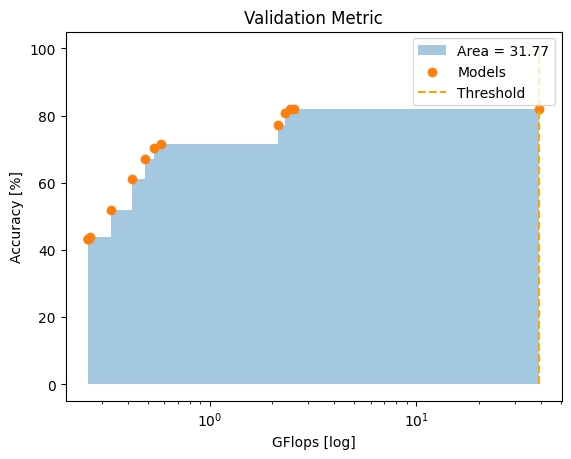

In [7]:
fxr = flop[1::4][:4]
axr = acc[1::4][:4]

f = flop[0::4][1:]
a = acc[0::4][1:]

f_tot = f + fxr
a_tot = a + axr
f_tot.sort()
a_tot.sort()
plt.fill_between(f_tot + [39.32], a_tot + [a_tot[-1]], step="post", alpha=0.4, label = "Area = 31.77" )
plt.scatter(f_tot + [39.32],a_tot + [a_tot[-1]], label = "Models")
# plt.scatter(fxr, axr)
plt.vlines(39.32,0,100, color = "orange", linestyle = "--", label = "Threshold")

plt.title("Validation Metric")
plt.ylabel("Accuracy [%]")
plt.xlabel("GFlops [log]")
plt.xscale('log')
plt.legend()

In [ ]:
acc = [91.439, 87.242, 91.483, 87.201, 90.769, 86.679, 88.71, 84.677, 84.153, 80.184, 76.605, 70.962, 69.591, 59.917, 68.885, 58.226, 69.217, 58.209, 68.99, 58.306, 69.146, 58.462]
flop = [0.6232760320000049, 0.6353469439999969, 0.5509481371648002, 0.58939660115968, 0.4911502452736001, 0.5433320809267197, 0.4346228992000005, 0.49223339220992063, 0.37512414597120003, 0.4302773958246397, 0.31004249907200004, 0.3467559808204801, 0.2617201606656005, 0.2657943897702401, 0.2571960319999994, 0.2546401280000012, 0.2571960319999994, 0.2546401280000012, 0.2571960319999994, 0.2546401280000012, 0.2571960319999994, 0.2546401280000012]
acc1 =  [93.84717039800995, 89.0663868159204, 93.67615049751244, 88.95172574626865, 92.81716417910448, 87.67490671641791, 89.97784514925372, 84.90749378109453, 84.08737562189054, 78.15415111940298, 72.73009950248756, 66.04283271144278, 57.53264925373134, 50.792910447761194, 54.24440298507463, 46.64373445273632, 54.03257151741293, 46.40663868159204, 53.98592972636816, 46.44939365671642, 54.269667288557216, 46.593205845771145]
flop1 =  [2.54015897599999, 2.4918753279999946, 2.3817657816517417, 2.350401258348258, 2.1994661877810944, 2.2047534589452744, 2.003635187900498, 2.0333276185472644, 1.7627888525373148, 1.8025373395422877, 1.45591740720398, 1.4881745932736328, 1.0992369999601994, 1.1298596846169162, 1.0185605119999956, 1.0287841280000039, 1.0185605119999956, 1.0287841280000039, 1.0185605119999956, 1.0287841280000039, 1.0185605119999956, 1.0287841280000039]

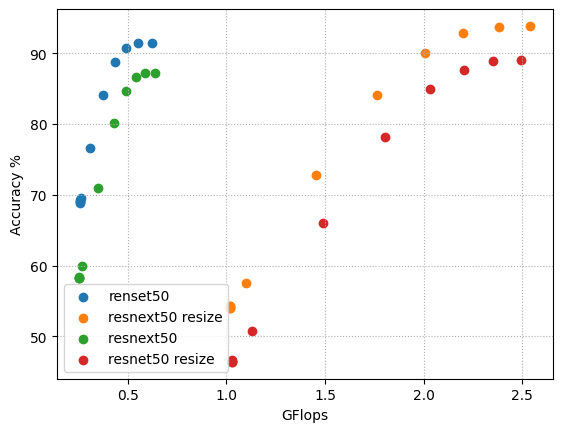

In [ ]:
plt.scatter(flop[0::2],acc[0::2], label = "renset50")
plt.scatter(flop1[0::2],acc1[0::2],label = "resnext50 resize")
plt.scatter(flop[1::2],acc[1::2],label = "resnext50 ")
plt.scatter(flop1[1::2],acc1[1::2], label = "resnet50 resize")
plt.legend()
plt.xlabel("GFlops")
plt.ylabel("Accuracy %")
plt.grid(linestyle=':')


# for i, txt in enumerate(np.linspace(1,7, 30)[0:3]):
#     plt.annotate(f"T{i}: {txt:.2f}", (flop[i], acc[i]))

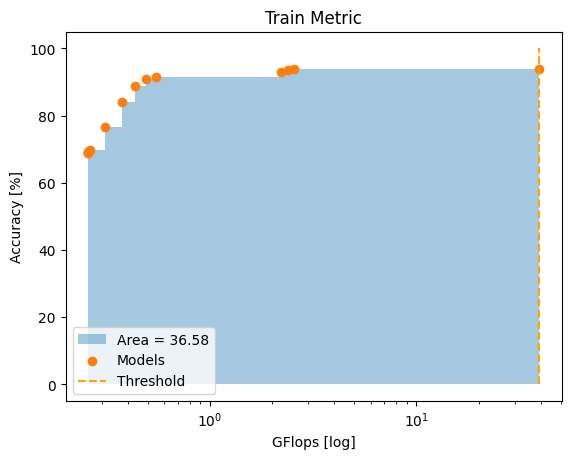

In [ ]:
fxr = flop1[0::2][:3]
axr = acc1[0::2][:3]

f = flop[0::2][1:]
a = acc[0::2][1:]

f_tot = f + fxr
a_tot = a + axr
f_tot.sort()
a_tot.sort()
plt.fill_between(f_tot + [39.32], a_tot + [a_tot[-1]], step="post", alpha=0.4, label = "Area = 36.58" )
plt.scatter(f_tot + [39.32],a_tot + [a_tot[-1]], label = "Models")
# plt.scatter(fxr, axr)
plt.vlines(39.32,0,100, color = "orange", linestyle = "--", label = "Threshold")

plt.title("Train Metric")
plt.ylabel("Accuracy [%]")
plt.xlabel("GFlops [log]")
plt.xscale('log')
plt.legend()

In [ ]:
def metric(Ens, Accs):
    e_max = 39.32
    AUC = 0
    Ens, Accs = zip(*sorted(zip(Ens, Accs)))
    Ens, Accs = list(Ens),list(Accs)
    # Ens.append(e_max)
    for i in range(len(Ens)-1):
      AUC = AUC + Accs[i] * (Ens[i+1]-Ens[i])
    return AUC

def metric(Ens, Accs):
    e_max = 39.32
    AUC = 0
    Ens, Accs = zip(*sorted(zip(Ens, Accs)))
    Ens, Accs = list(Ens),list(Accs)
    Ens.append(e_max)
    for i in range(len(Ens)-1):
      AUC = AUC + Accs[i] * (Ens[i+1]-Ens[i])
    return AUC

In [ ]:
f_r_50, a_r_50  =  flop[0::2][1:4],acc[0::2][1:4]
f_rx_50_128, a_rx_50_128  =  flop1[0::2][0:3],acc1[0::2][0:3]

flop_50, acc_50 = flop[0::4][1:4],acc[0::4][1:4]
flop_50X_128, acc_50X_128 = flop[1::4][0:3],acc[1::4][0:3]
flop_50_128, acc_50_128 = flop[3::4][0:3],acc[3::4][0:3]
flop_50X, acc_50X = flop[2::4][0:4],acc[2::4][0:4]

# flop_ordered = flop_50X_128 + flop_50_128 + flop_50X +flop_50
# acc_ordered = acc_50X_128 + acc_50_128 + acc_50X +acc_50

flop_ordered = flop_50X_128+ flop_50X +flop_50
acc_ordered = acc_50X_128 + acc_50X +acc_50

flop_ordered = flop_50X_128 +flop_50
acc_ordered = acc_50X_128 +acc_50

# flop_ordered = f_rx_50_128 + f_r_50
# acc_ordered = a_rx_50_128 + a_r_50

print(len(acc_ordered), len(flop_ordered))
metric_score1 = print(metric(flop_ordered,acc_ordered)/100)

# acc_ordered = [max(acc_ordered)] + acc_ordered
# flop_ordered = [0] + flop_ordered
# print(len(acc_ordered), len(flop_ordered))

6 6
31.655503769463806


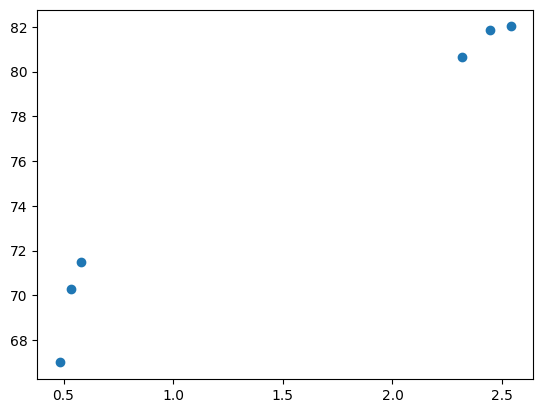

In [ ]:
plt.scatter(flop_ordered, acc_ordered)

In [ ]:
print(acc_ordered)
print(flop_ordered)

[82.02, 81.86, 80.67, 71.49, 70.29, 67.0]
[2.5401589760000003, 2.4431966814208, 2.3172579475456, 0.5795743211520001, 0.5353370767359998, 0.48407488716800007]


In [ ]:
# In this cell you can find the values that we selected to submit for the challenge and below the graph accuracy vs flops.

# flop_ordered = [2.5401589760000003, 2.4431966814208, 2.3172579475456, 2.1454147485696002, 0.6353469439999995, 0.6015775629311999, 0.5642347585536002, 0.5175347339264, 0.45417077473280015, 0.35772901621760006, 0.266657255424]
# acc_ordered = [82.02, 81.86, 80.67, 77.2, 72.0, 71.87, 70.96, 68.45, 63.48, 54.18, 43.57]
# print(flop_ordered)
# print(acc_ordered)

In [ ]:
metric2([1/0.01, 1/0.39, 1/0.69, 1/1.09, 1/1.83, 1/4.39, 1/10.27, 1/19.07, 1/37.75],[0.05, .77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122])

6.906871292422957

In [ ]:
acc_to_plot = [i/100 for i in acc_ordered]

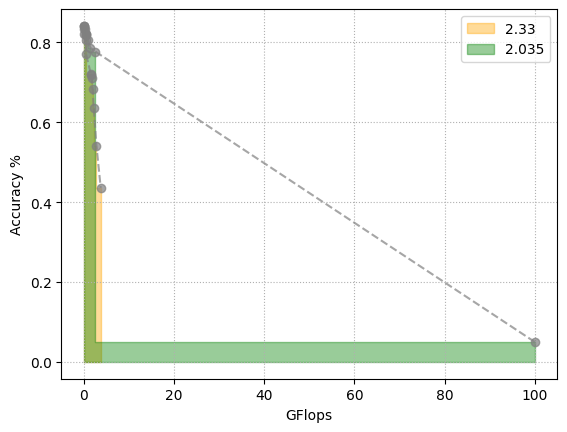

In [ ]:
# import matplotlib.pyplot as plt

# plt.scatter(flop_ordered, acc_ordered, label = f"Area = 31.78")
plt.plot(flop_ordered, acc_to_plot, 'o--', color='grey', alpha=0.7)
plt.fill_between(flop_ordered, acc_to_plot, step="pre", alpha=0.4, label=f'{round(2.33,3)}' , color = "orange")

efficientnet_accuracies = [0.05,.77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122, .84122]
efficientnet_flops = [0.01 , 0.39, 0.69, 1.09, 1.83, 4.39, 10.27, 19.07, 37.75, 1e30]
efficientnet_flops = [1/i for i in efficientnet_flops ]
plt.plot(efficientnet_flops, efficientnet_accuracies, 'o--', color='grey', alpha=0.7)
plt.fill_between(efficientnet_flops, efficientnet_accuracies, step="post", alpha=0.4, label=f'{round(2.035,3)}' , color = "green")
# plt.xlabel("GFlops")
# plt.ylabel("Accuracy %")
# plt.grid(linestyle=':')
# plt.legend()


plt.xlabel("GFlops")
plt.ylabel("Accuracy %")
plt.grid(linestyle=':')



plt.legend()

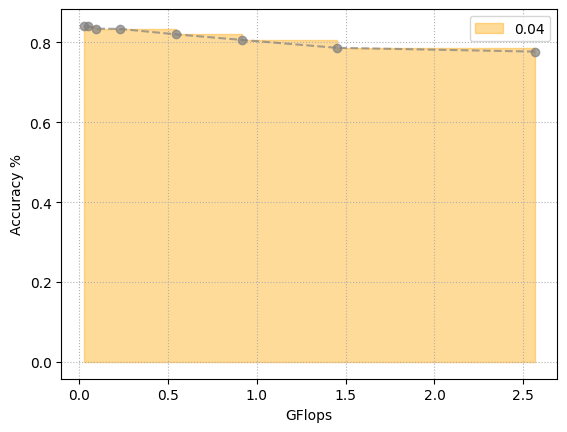

In [ ]:
efficientnet_accuracies = [.77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122]
efficientnet_flops = [0.39, 0.69, 1.09, 1.83, 4.39, 10.27, 19.07, 37.75]
efficientnet_flops = [1/i for i in efficientnet_flops ]
plt.plot(efficientnet_flops, efficientnet_accuracies, 'o--', color='grey', alpha=0.7)
plt.fill_between(efficientnet_flops, efficientnet_accuracies, step="pre", alpha=0.4, label=f'{round(metric2(efficientnet_flops,efficientnet_accuracies)/100,3)}' , color = "orange")
plt.xlabel("GFlops")
plt.ylabel("Accuracy %")
plt.grid(linestyle=':')
plt.legend()

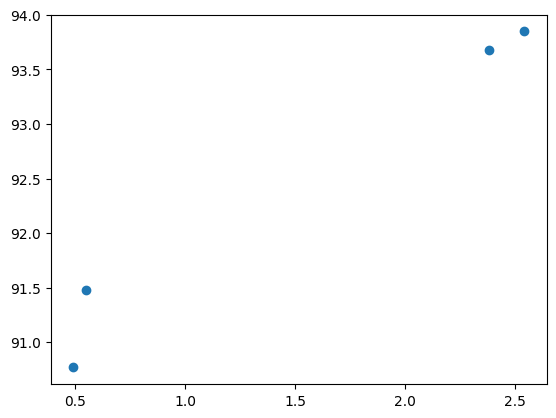

In [ ]:
plt.scatter(flop_ordered, acc_ordered)

In [ ]:
print(metric(flop_ordered,acc_ordered)/100)

1.877541501312195


In [ ]:
31.782136448054885

In [ ]:
def metric2(Ens, Accs):
  Ens, Accs = zip(*sorted(zip(Ens, Accs)))
  Ens, Accs = list(Ens),list(Accs)
  # print(Ens)
  # print(Accs)
  AUC = 0
  for i in range(1,len(Ens)):
    AUC = AUC + Accs[i] * (Ens[i]-Ens[i-1])
  return AUC

In [ ]:
metric2(efficientnet_flops,efficientnet_accuracies)/100

[9.999999999999999e-31, 0.026490066225165563, 0.05243838489774515, 0.09737098344693282, 0.22779043280182235, 0.5464480874316939, 0.9174311926605504, 1.4492753623188408, 2.564102564102564]
[0.84122, 0.84122, 0.84008, 0.83444, 0.83384, 0.82008, 0.80608, 0.78642, 0.77692]


0.020350764206280843

In [ ]:
print(metric2(flop_ordered,acc_ordered)/100)

[0, 0.3936761476144712, 0.4092998355819912, 0.43154453351176675, 0.4661103409803275, 1.5739431966166832, 1.6622960389803736, 1.77231194080186, 1.932237460495188, 2.201814946345512, 2.795412042817679, 3.750132350270927]
[0.8201999999999999, 0.8201999999999999, 0.8186, 0.8067, 0.772, 0.72, 0.7187, 0.7095999999999999, 0.6845, 0.6347999999999999, 0.5418, 0.4357]
0.023376978073006364


# Test new metric

In [ ]:
def metric3(Ens, Accs):


  Ens = [1/(i+1) for i in Ens]
  Ens, Accs = zip(*sorted(zip(Ens, Accs)))
  Ens, Accs = list(Ens),list(Accs)

  AUC = [0]
  for i in range(len(Ens)):
    AUC.append(AUC[-1] + Accs[i] * Ens[i])

  Ens = [0] + Ens

  return AUC, Ens



def metric4(Ens, Accs):

  Ens = [1/(i+1) for i in Ens]

  Ens = [0] + Ens
  Accs = [max(Accs)]+Accs

  Ens, Accs = zip(*sorted(zip(Ens, Accs)))
  Ens, Accs = list(Ens),list(Accs)



  print(Ens)
  print(Accs)

  AUC = 0
  for i in range(1, len(Ens)):
    AUC = AUC + Accs[i] * (Ens[i]-Ens[i-1])

  return AUC, Ens, Accs


def metric5(Ens, Accs):

  Ens = [1/(np.log(i+1)+1) for i in Ens]

  Ens = [0] + Ens
  Accs = [max(Accs)]+Accs

  Ens, Accs = zip(*sorted(zip(Ens, Accs)))
  Ens, Accs = list(Ens),list(Accs)



  print(Ens)
  print(Accs)

  AUC = 0
  for i in range(1, len(Ens)):
    AUC = AUC + Accs[i] * (Ens[i]-Ens[i-1])

  return AUC, Ens, Accs

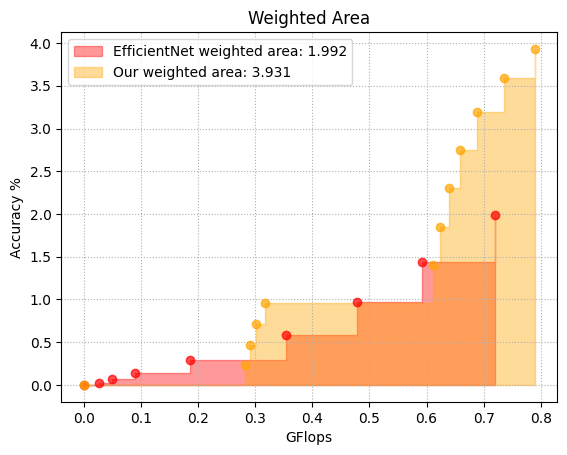

In [ ]:
efficientnet_accuracies = [.77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122]
efficientnet_flops = [ 0.39, 0.69, 1.09, 1.83, 4.39, 10.27, 19.07, 37.75]

flop_ordered = [2.5401589760000003, 2.4431966814208, 2.3172579475456, 2.1454147485696002, 0.6353469439999995, 0.6015775629311999, 0.5642347585536002, 0.5175347339264, 0.45417077473280015, 0.35772901621760006, 0.266657255424]
acc_ordered = [82.02, 81.86, 80.67, 77.2, 72.0, 71.87, 70.96, 68.45, 63.48, 54.18, 43.57]
acc_ordered = [i/100 for i in acc_ordered]


AUC, Ens = metric3(efficientnet_flops, efficientnet_accuracies)
AUC_1, Ens_1 = metric3(flop_ordered, acc_ordered)


plt.plot(Ens, AUC, 'o', color='red', alpha=0.7)
plt.fill_between(Ens, AUC, step="post", alpha=0.4, label=f'EfficientNet weighted area: {round(AUC[-1],3)}' , color = "red")

plt.plot(Ens_1, AUC_1, 'o', color='orange', alpha=0.7)
plt.fill_between(Ens_1, AUC_1, step="post", alpha=0.4, label=f'Our weighted area: {round(AUC_1[-1],3)}' , color = "orange")

plt.title("Weighted Area")
plt.xlabel("GFlops")
plt.ylabel("Accuracy %")
plt.grid(linestyle=':')
plt.legend()

[0, 0.025806451612903226, 0.04982561036372696, 0.08873114463176575, 0.1855287569573284, 0.35335689045936397, 0.47846889952153115, 0.591715976331361, 0.7194244604316546]
[0.84122, 0.84122, 0.84008, 0.83444, 0.83384, 0.82008, 0.80608, 0.78642, 0.77692]
[0, 0.2824731902661311, 0.2904277892099269, 0.3014537958194925, 0.6330819554414442, 0.6513227714958317, 0.6738204444037588]
[0.8201999999999999, 0.8201999999999999, 0.8186, 0.8067, 0.7149, 0.7029000000000001, 0.67]


(0.0, 1.0)

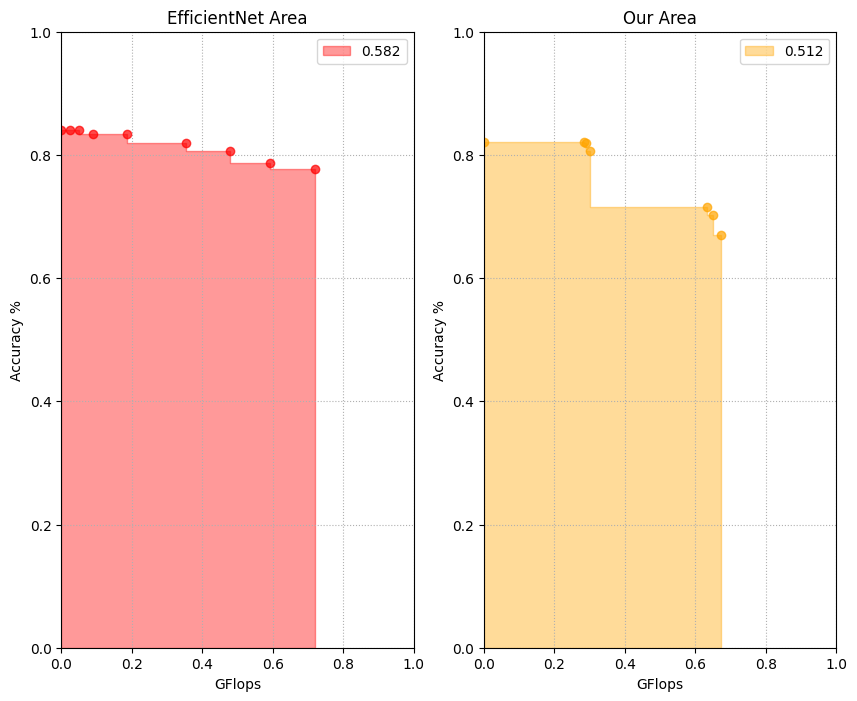

In [ ]:
efficientnet_accuracies = [.77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122]
efficientnet_flops = [ 0.39, 0.69, 1.09, 1.83, 4.39, 10.27, 19.07, 37.75]

# flop_ordered = [2.5401589760000003, 2.4431966814208, 2.3172579475456, 2.1454147485696002, 0.6353469439999995, 0.6015775629311999, 0.5642347585536002, 0.5175347339264, 0.45417077473280015, 0.35772901621760006, 0.266657255424]
# acc_ordered = [82.02, 81.86, 80.67, 77.2, 72.0, 71.87, 70.96, 68.45, 63.48, 54.18, 43.57]

acc_ordered = [82.02, 81.86, 80.67, 71.49, 70.29, 67.0]
flop_ordered = [2.5401589760000003, 2.4431966814208, 2.3172579475456, 0.5795743211520001, 0.5353370767359998, 0.48407488716800007]

acc_ordered = [i/100 for i in acc_ordered]


AUC, Ens, Accs = metric4(efficientnet_flops, efficientnet_accuracies)
AUC_1, Ens_1, Accs_1 = metric4(flop_ordered, acc_ordered)


fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].set_title("EfficientNet Area")
ax[0].plot(Ens, Accs, 'o', color='red', alpha=0.7)
ax[0].fill_between(Ens, Accs, step="pre", alpha=0.4, label=f'{round(AUC,3)}' , color = "red")

ax[0].set_xlabel("GFlops")
ax[0].set_ylabel("Accuracy %")
ax[0].grid(linestyle=':')
ax[0].legend()
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))


ax[1].plot(Ens_1, Accs_1, 'o', color='orange', alpha=0.7)
ax[1].fill_between(Ens_1, Accs_1, step="pre", alpha=0.4, label=f'{round(AUC_1,3)}' , color = "orange")

ax[1].set_title("Our Area")
ax[1].set_xlabel("GFlops")
ax[1].set_ylabel("Accuracy %")
ax[1].grid(linestyle=':')
ax[1].legend()
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))

[0, 0.21472448433077304, 0.25004837418292003, 0.2922144433836097, 0.3725025494510173, 0.49012959579819143, 0.5756508665966162, 0.6558544560706139, 0.7522735132203952]
[0.84122, 0.84122, 0.84008, 0.83444, 0.83384, 0.82008, 0.80608, 0.78642, 0.77692]
[0, 0.44166263047960475, 0.4471471393291813, 0.45472351554033436, 0.46599500324726584, 0.6703064395693801, 0.6798146812813969, 0.6908955766779615, 0.7056729095853185, 0.7275712569623629, 0.7658061647702347, 0.808811942634127]
[0.8201999999999999, 0.8201999999999999, 0.8186, 0.8067, 0.772, 0.72, 0.7187, 0.7095999999999999, 0.6845, 0.6347999999999999, 0.5418, 0.4357]


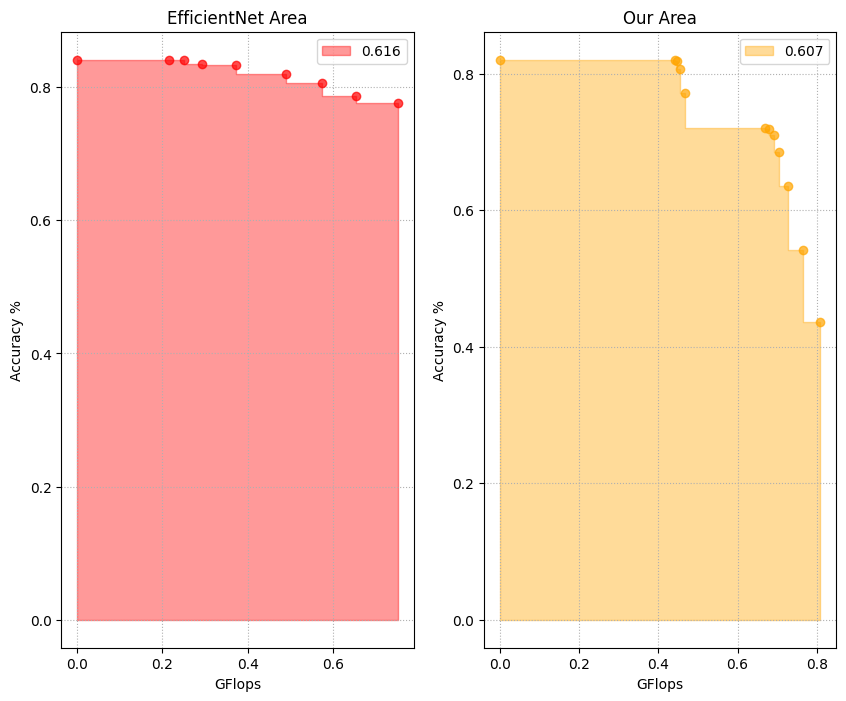

In [ ]:
efficientnet_accuracies = [.77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122]
efficientnet_flops = [ 0.39, 0.69, 1.09, 1.83, 4.39, 10.27, 19.07, 37.75]

flop_ordered = [2.5401589760000003, 2.4431966814208, 2.3172579475456, 2.1454147485696002, 0.6353469439999995, 0.6015775629311999, 0.5642347585536002, 0.5175347339264, 0.45417077473280015, 0.35772901621760006, 0.266657255424]
acc_ordered = [82.02, 81.86, 80.67, 77.2, 72.0, 71.87, 70.96, 68.45, 63.48, 54.18, 43.57]
acc_ordered = [i/100 for i in acc_ordered]


AUC, Ens, Accs = metric5(efficientnet_flops, efficientnet_accuracies)
AUC_1, Ens_1, Accs_1 = metric5(flop_ordered, acc_ordered)


fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].set_title("EfficientNet Area")
ax[0].plot(Ens, Accs, 'o', color='red', alpha=0.7)
ax[0].fill_between(Ens, Accs, step="pre", alpha=0.4, label=f'{round(AUC,3)}' , color = "red")

ax[0].set_xlabel("GFlops")
ax[0].set_ylabel("Accuracy %")
ax[0].grid(linestyle=':')
ax[0].legend()


ax[1].plot(Ens_1, Accs_1, 'o', color='orange', alpha=0.7)
ax[1].fill_between(Ens_1, Accs_1, step="pre", alpha=0.4, label=f'{round(AUC_1,3)}' , color = "orange")

ax[1].set_title("Our Area")
ax[1].set_xlabel("GFlops")
ax[1].set_ylabel("Accuracy %")
ax[1].grid(linestyle=':')
ax[1].legend()

# Size vs flops

In [ ]:
model_50 = path + "/models/resnet50earlycutmix_model.torch"
model_50X = path + "/models/resnext50earlycutmix_64_model.torch"
model_50_128 = path + "/Resize/ResNet50_128_parameters.torch"
model_50X_128 = path + "/Resize/ResNeXt50_128_parameters.torch"

In [ ]:
# Loading the models with different entropy threshold
models = []
weights = []
for T in Threshold:
  # models.append(EarlyExitCustomNet64(device,resnext = False,T=T))
  # weights.append(torch.load(model_50))
  models.append(EarlyExitCustomNet128(device,T=T))
  weights.append(torch.load(model_50X_128 ))
  # models.append(EarlyExitCustomNet64(device,T=T))
  # weights.append(torch.load(model_50X))
  models.append(EarlyExitCustomNet128( device, resnext = False, T=T))
  weights.append(torch.load(model_50_128 ))

In [ ]:
sizes = np.arange(64,512, 32)
# model = EarlyExitCustomNet64(device,resnext = False,T=0)
# weight = torch.load(model_50)

<ipython-input-11-879737485dc2>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(model_50)


In [ ]:
flop = []
for j, s in enumerate(sizes):

        validation_dataset = CreateDataset(augmentation = True, train = False, data_path = data_path, resize = s)
        val_dataloader = DataLoader(validation_dataset, batch_size=batches_size,
                        shuffle=False, num_workers=0)
        print( f"################# {j} ###############")
        model = torchvision.models.resnet50(pretrained=True)
        model = model.to(device)
        model.eval()

        start = time.time()
        total =  0
        total_flops = 0
        correct = 0

        y_true=[]
        y_pred=[]

        # hist=[]

        val_dataloader = val_dataloader

        with torch.no_grad():
            for i, data in enumerate(val_dataloader):

                # print(f"BATCH {i}")

                inputs = data['images']
                inputs = inputs.to(device)


                labels = torch.squeeze(data['labels'])
                labels = labels.to(device)


                outputs = model(inputs.float())
                outputs.to(device)

                predicted = model(inputs.float())

                y_pred.append(predicted)
                y_true.append(labels)

                # Compute FLOPs
                flops = FlopCountAnalysis(model, inputs).tracer_warnings(mode='none')
                total_flops += flops.total()/10**9 # in Giga Flops

                print(f"FLOPS {flops.total()}")

                total += labels.size(0)

                if i == 50:
                  break


            energy = total_flops / total

            flop.append(energy)

        end = time.time()
        print(f"################### Time: {end-start} ######################")


################# 0 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 86403710976
FLOPS 5400231936
################### Time: 10.303771734237671 ######################
################# 1 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 193752989696
FLOPS 12109561856
################### Time: 17.079906463623047 ######################
################# 2 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 344041979904
FLOPS 21502623744
################### Time: 26.24770450592041 ######################
################# 3 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 537270681600
FLOPS 33579417600
################### Time: 42.559000730514526 ######################
################# 4 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 773439094784
FLOPS 48339943424
################### Time: 59.65147256851196 ######################
################# 5 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 1052547219456
FLOPS 65784201216
################### Time: 83.2885434627533 ######################
################# 6 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 1374595055616
FLOPS 85912190976
################### Time: 104.3498592376709 ######################
################# 7 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 1739582603264
FLOPS 108723912704
################### Time: 142.79780983924866 ######################
################# 8 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 2147509862400
FLOPS 134219366400
################### Time: 172.99129843711853 ######################
################# 9 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 2598376833024
FLOPS 162398552064
################### Time: 213.34676790237427 ######################
################# 10 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 3092183515136
FLOPS 193261469696
################### Time: 245.65634036064148 ######################
################# 11 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 3628929908736
FLOPS 226808119296
################### Time: 300.8758976459503 ######################
################# 12 ###############


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.06 GiB. GPU 0 has a total capacity of 14.75 GiB of which 2.92 GiB is free. Process 4254 has 11.82 GiB memory in use. Of the allocated memory 7.84 GiB is allocated by PyTorch, and 3.86 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Text(0.5, 1.0, 'GFlops per image')

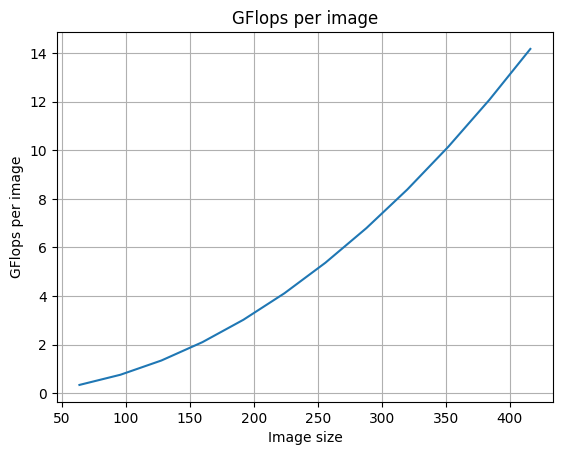

In [ ]:
plt.plot(sizes[0:12],flop, label = "GFlops per image")
plt.grid()
plt.xlabel("Image size")
plt.ylabel("GFlops per image")
plt.title("GFlops per image")

In [ ]:
sizes[0:12]
print(flop)

[0.3375144960000002, 0.7568476160000006, 1.3439139839999987, 2.098713599999998, 3.0212464640000003, 4.111512575999998, 5.369511936000003, 6.795244544000005, 8.388710399999999, 10.149909503999995, 12.078841855999997, 14.175507455999995]
